In [ ]:
from pathlib import Path
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import aggregate_downsample
from astropy.timeseries import TimeSeries

import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def boundify(a, sigma=2.0):
    mean = a.mean()
    dev = np.std(a)
    
    return (mean - (sigma * dev)).value, (mean + (sigma * dev)).value

def check_filter(labels):
    values = []
    
    for label in labels:
        if re.match(r'.*_B[0-9]+_.*', str(label)):
            values.append('Blue')
        elif re.match(r'.*_V[0-9]+_.*', str(label)):
            values.append('Green')
        elif re.match(r'.*_R[0-9]+_.*', str(label)):
            values.append('Red')
        else:
            values.append('Unknown')
    
    return values


In [3]:
# constants
working_directory = Path('/home/localadmin')
csv_data = working_directory / 'measurements.csv'
swasp_data = working_directory / ''

# TODO: automatically infer this from the FITS data
period = 10.903858 * u.hour

In [4]:
t = Table.read(csv_data, format='ascii.csv', delimiter=',', fast_reader=False)
# curate columns
t['JD_UTC'].unit = u.day
t['time'] = Time(t['JD_UTC'], format='jd')
t['filter'] = check_filter(t['Label'])

for row in t:
    check_filter(row)

# remove unwanted data
t.keep_columns(['time','rel_flux_T1', 'rel_flux_err_T1', 'filter'])
t['rel_flux_T1'].unit = 'mag'

In [5]:
ts = TimeSeries(t)
t

rel_flux_T1,rel_flux_err_T1,time,filter
mag,,,
float64,float64,object,str5
0.010416,4.3e-05,2458938.635252,Red
0.011052,4.9e-05,2458952.552465,Red
0.009983,5.4e-05,2458952.571337,Red
0.006994,0.00016,2458952.581071,Red
0.011277,6.2e-05,2458952.709732,Red
0.008776,4.3e-05,2458953.579491,Red
0.007768,3.4e-05,2458955.489258,Red
0.007661,3.5e-05,2458955.662609,Red


In [27]:
ts_folded = ts.fold(period=period, normalize_phase=True, wrap_phase=1.0)
ts_folded.sort('time')

period.to(u.hour)

<Quantity 10.903858 h>

Text(0, 0.5, 'SAP Flux (e-/s)')

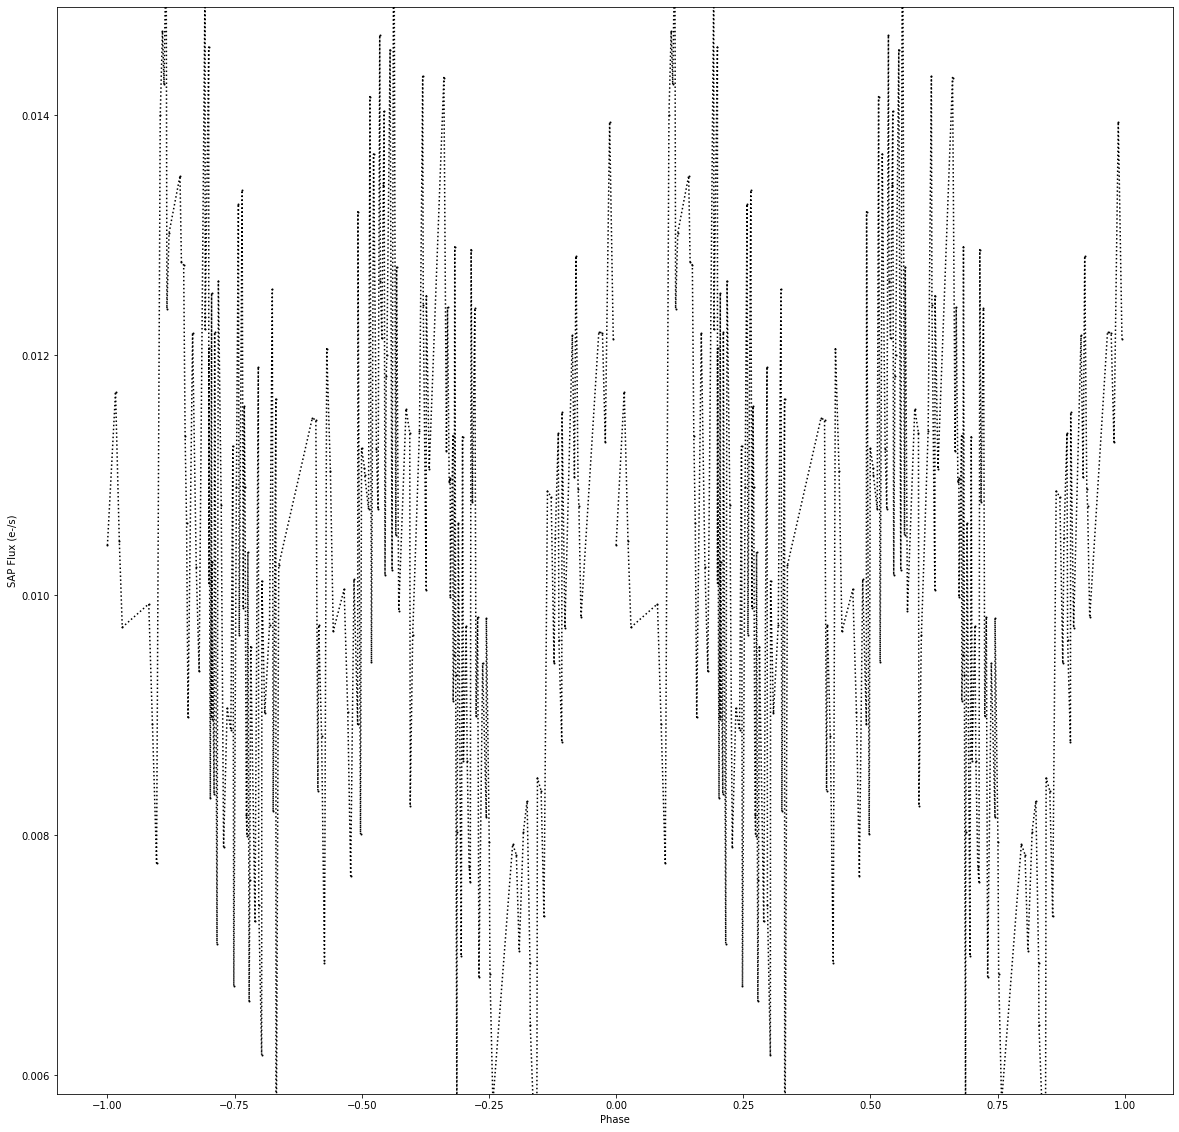

In [28]:
y_min, y_max = boundify(ts_folded['rel_flux_T1'])

plt.figure(figsize=(20,20))
plt.plot(ts_folded.time, ts_folded['rel_flux_T1'], 'k.', markersize=2, linestyle=':')
plt.plot(ts_folded.time - 1.0, ts_folded['rel_flux_T1'], 'k.', markersize=2, linestyle=':')
plt.ylim(bottom=y_min, top=y_max)
plt.xlabel('Phase')
plt.ylabel('SAP Flux (e-/s)')

In [29]:
# seperate the colour channels
ts_red = ts_folded[ts_folded['filter'] == 'Red']
ts_green = ts_folded[ts_folded['filter'] == 'Green']
ts_blue = ts_folded[ts_folded['filter'] == 'Blue']

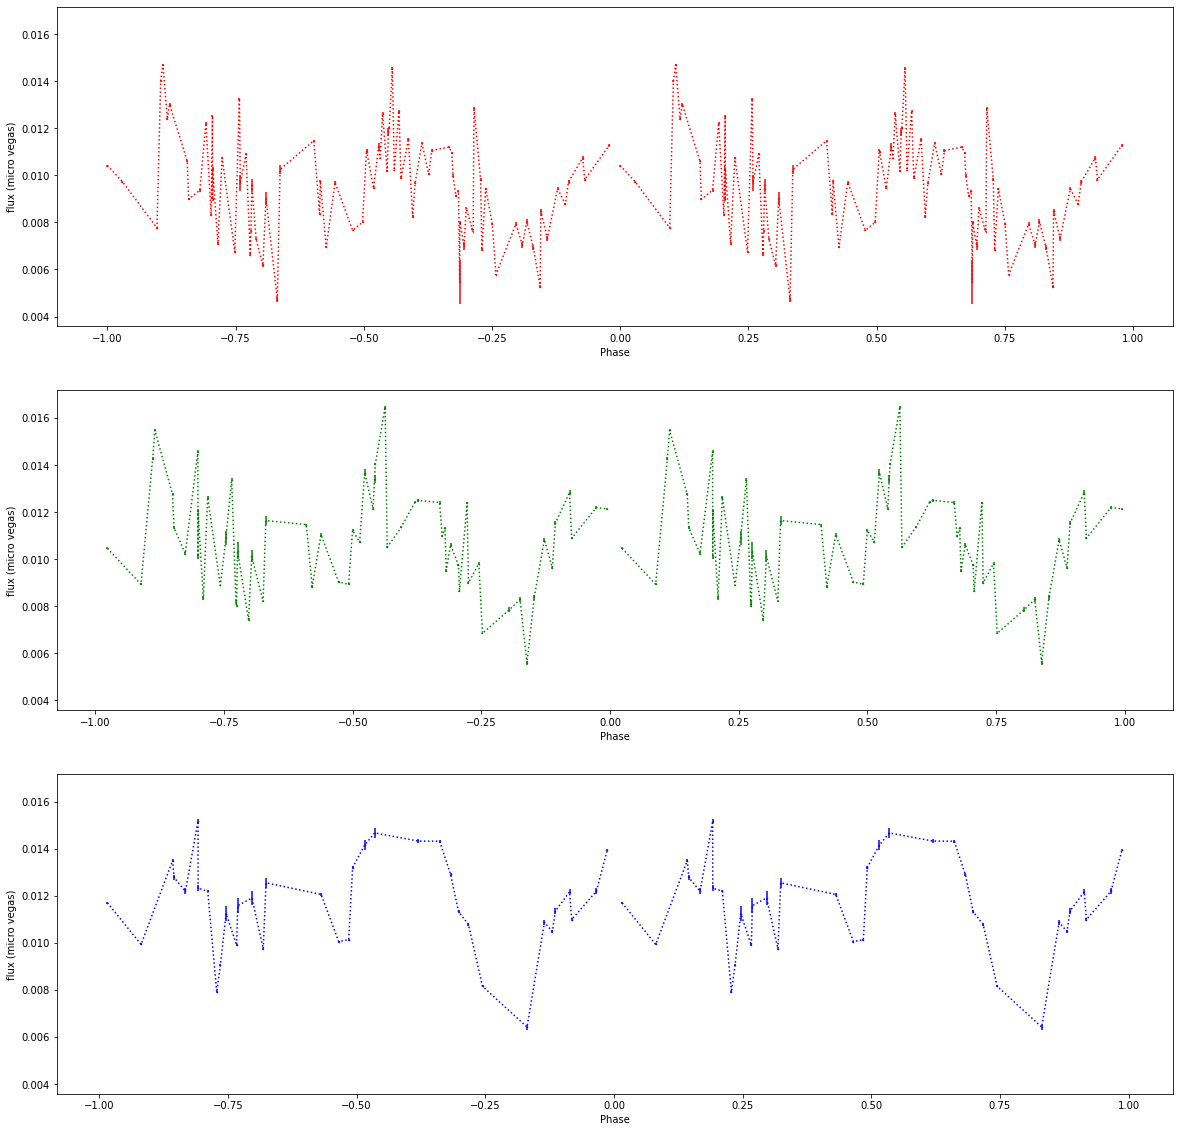

In [30]:
y_min, y_max = boundify(ts_folded['rel_flux_T1'], sigma=3)

fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(311)
ax1.errorbar(ts_red.time, ts_red['rel_flux_T1'].value, yerr=ts_red['rel_flux_err_T1'], fmt='r.', markersize=1, linestyle=':')
ax1.errorbar(ts_red.time - 1.0, ts_red['rel_flux_T1'].value, yerr=ts_red['rel_flux_err_T1'], fmt='r.', markersize=1, linestyle=':')
ax1.set_ylim(y_min, y_max)
ax1.set_xlabel('Phase')
ax1.set_ylabel('flux (micro vegas)')

ax2 = fig.add_subplot(312)
ax2.errorbar(ts_green.time, ts_green['rel_flux_T1'].value, yerr=ts_green['rel_flux_err_T1'], fmt='g.', markersize=1, linestyle=':')
ax2.errorbar(ts_green.time - 1.0, ts_green['rel_flux_T1'].value, yerr=ts_green['rel_flux_err_T1'], fmt='g.', markersize=1, linestyle=':')
ax2.set_ylim(y_min, y_max)
ax2.set_xlabel('Phase')
ax2.set_ylabel('flux (micro vegas)')

ax3 = fig.add_subplot(313)
ax3.errorbar(ts_blue.time, ts_blue['rel_flux_T1'].value, yerr=ts_blue['rel_flux_err_T1'], fmt='b.', markersize=1, linestyle=':')
ax3.errorbar(ts_blue.time - 1.0, ts_blue['rel_flux_T1'].value, yerr=ts_blue['rel_flux_err_T1'], fmt='b.', markersize=1, linestyle=':')
ax3.set_ylim(y_min, y_max)
ax3.set_xlabel('Phase')
ax3.set_ylabel('flux (micro vegas)')

plt.show()